# Forecasting

In this section, I will model and forecast both company's trend in daily number of rides. As established in previous section, the daily profit, price charged and cost of the trip all depend on the daily number of trips. Therefore, I will use **daily number of trips as the target variable**. 
<br>
<br>
I will use **Facebook Prophet** for forecasting as it is the best for forecasting time-series data with constant seasonality.

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

I will use the master dataset prepared during the EDA.

In [2]:
df = pd.read_csv('full_df.csv')

df['travel_date'] = pd.to_datetime(df['travel_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   transaction_id  359392 non-null  int64         
 1   company         359392 non-null  object        
 2   city            359392 non-null  object        
 3   km_travelled    359392 non-null  float64       
 4   price_charged   359392 non-null  float64       
 5   cost_of_trip    359392 non-null  float64       
 6   travel_date     359392 non-null  datetime64[ns]
 7   customer_id     359392 non-null  int64         
 8   payment_mode    359392 non-null  object        
 9   gender          359392 non-null  object        
 10  age             359392 non-null  int64         
 11  cust_income     359392 non-null  int64         
 12  state           359392 non-null  object        
 13  year            359392 non-null  int64         
 14  month           359392 non-null  int

I will forecast both Cab companies separately and then compare them in the end.

# Yellow Cab

In [3]:
df['week'] = df['travel_date'].dt.weekofyear

In [4]:
yc_df = df.query('company == "Yellow Cab"').\
        groupby(['travel_date', 'year', 'month', 'week', 'date', 'day_of_week']).\
        size().reset_index().rename(columns = {0:'trips'})

yc_df

,travel_date,year,month,week,date,day_of_week,trips
0,2016-01-02,2016,1,53,2,5,140
1,2016-01-03,2016,1,53,3,6,126
2,2016-01-04,2016,1,1,4,0,21
3,2016-01-05,2016,1,1,5,1,41
4,2016-01-06,2016,1,1,6,2,86
...,...,...,...,...,...,...,...
1090,2018-12-27,2018,12,52,27,3,252
1091,2018-12-28,2018,12,52,28,4,626
1092,2018-12-29,2018,12,52,29,5,630
1093,2018-12-30,2018,12,52,30,6,201


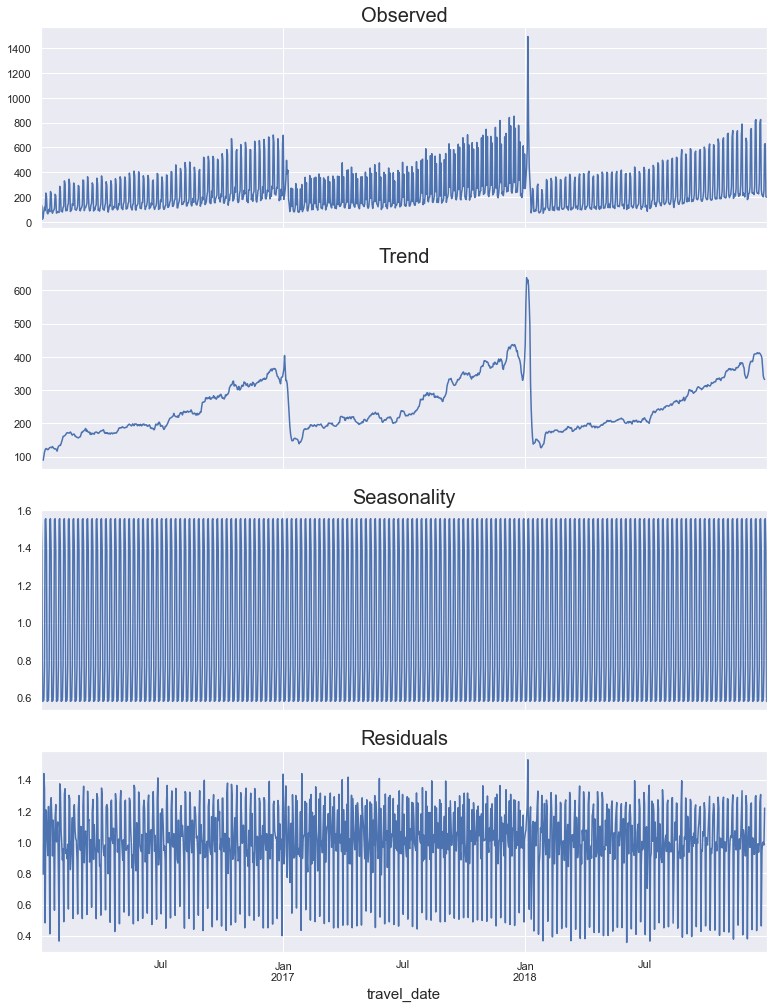

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(yc_df.set_index('travel_date')['trips'], model='mul')  # model='mul' also works

fig, (ax, ax1, ax2, ax3) = plt.subplots(4,1, figsize = (13,17), sharex = True);

result.observed.plot(ax = ax, title = 'Observed')
result.trend.plot(ax=ax1, title = 'Trend');
result.seasonal.plot(ax=ax2, title = 'Seasonality');
result.resid.plot(ax=ax3, title = 'Residuals');

The above plots breakdown the time series into the trend, seasonality and residual (error) components. I have used multiplicative model since, although there is a constant weekly seasonality, the monthly and yearly seasonality is not quite constant.
<br>
<br>
For the trend, there is an upward month-wise trend but the annual trend seems constant. There is a constant seasonality across all weeks. The residuals plot show no trend or seasonality, which is generally good.

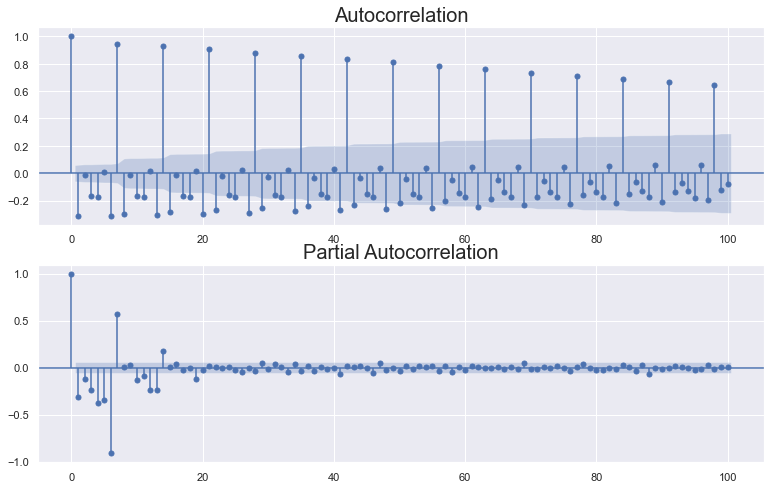

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag = 100

fig, ax = plt.subplots(2,1, figsize = (13,8))
plot_acf(yc_df.set_index('travel_date')['trips'].diff(1).dropna(), ax = ax[0], lags = lag);
plot_pacf(yc_df.set_index('travel_date')['trips'].diff(1).dropna(), ax = ax[1], lags = lag);

The ACF plot shows that a high auto correlation with the 7th lag, illustrating that the number of trips at present is correlated with the number of trips within the past week (7 days).
<br>
<br>
Since I will be using Facebook prophet for forecasting, I won't infer the p,d,q orders from these plots. 

In [7]:
#Inorder to improve model performance, I will create new features that is the daily trips 
#lagged by one step successively. Here, I am shiting 54 times.

for i in range(54, 0, -1): 
   yc_df['t-' + str(i)] = yc_df.trips.shift(i)

### Yellow Cab Forecast for next 90 days

In [8]:
yc_df.dropna(inplace = True)

In [9]:
#Rearraging and renaming both travel_date and target variable as required for forecasting using prophet.

yc_df = yc_df[[
    'travel_date', 'trips', 'year', 'month', 'week', 'date', 'day_of_week',
    't-54', 't-53', 't-52', 't-51', 't-50', 't-49', 't-48', 't-47', 't-46',
    't-45', 't-44', 't-43', 't-42', 't-41', 't-40', 't-39', 't-38', 't-37',
    't-36', 't-35', 't-34', 't-33', 't-32', 't-31', 't-30', 't-29', 't-28',
    't-27', 't-26', 't-25', 't-24', 't-23', 't-22', 't-21', 't-20', 't-19',
    't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10',
    't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']].reset_index(drop = True)

yc_df.rename(columns = {'travel_date' : 'ds', 'trips' : 'y'}, inplace = True)
yc_df.head()

,ds,y,year,month,week,date,day_of_week,t-54,t-53,t-52,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,2016-02-25,108,2016,2,8,25,3,140.0,126.0,21.0,...,83.0,91.0,99.0,146.0,132.0,313.0,286.0,101.0,96.0,94.0
1,2016-02-26,131,2016,2,8,26,4,126.0,21.0,41.0,...,91.0,99.0,146.0,132.0,313.0,286.0,101.0,96.0,94.0,108.0
2,2016-02-27,293,2016,2,8,27,5,21.0,41.0,86.0,...,99.0,146.0,132.0,313.0,286.0,101.0,96.0,94.0,108.0,131.0
3,2016-02-28,283,2016,2,8,28,6,41.0,86.0,117.0,...,146.0,132.0,313.0,286.0,101.0,96.0,94.0,108.0,131.0,293.0
4,2016-02-29,94,2016,2,9,29,0,86.0,117.0,90.0,...,132.0,313.0,286.0,101.0,96.0,94.0,108.0,131.0,293.0,283.0


In [10]:
#Train-test splitting. I will assign a period of 90 days for the test set.

nobs = 90
period = len(yc_df) - nobs

train = yc_df.iloc[:period]
test = yc_df.iloc[period:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


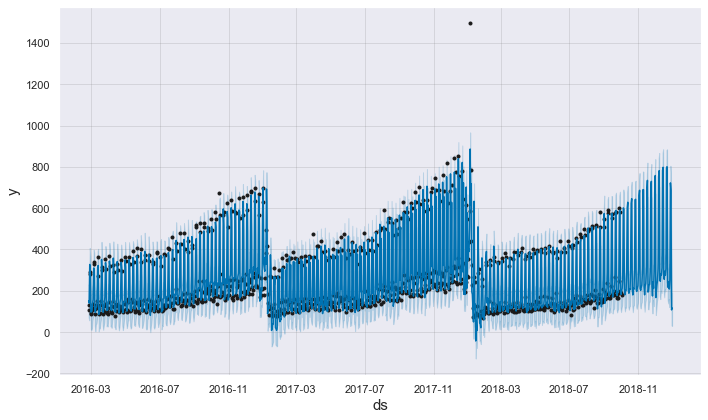

In [11]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95, seasonality_mode='multiplicative')

for i in yc_df.columns[2:]: #Adding all independent variables
    model.add_regressor(i)

model.fit(train)
future = model.make_future_dataframe(periods=nobs)

for i in yc_df.columns[2:]: 
    future[i] = yc_df[i]

forecast = model.predict(future)

model.plot(forecast);

We can see that the forecasts closely follows the patterns of previous days.

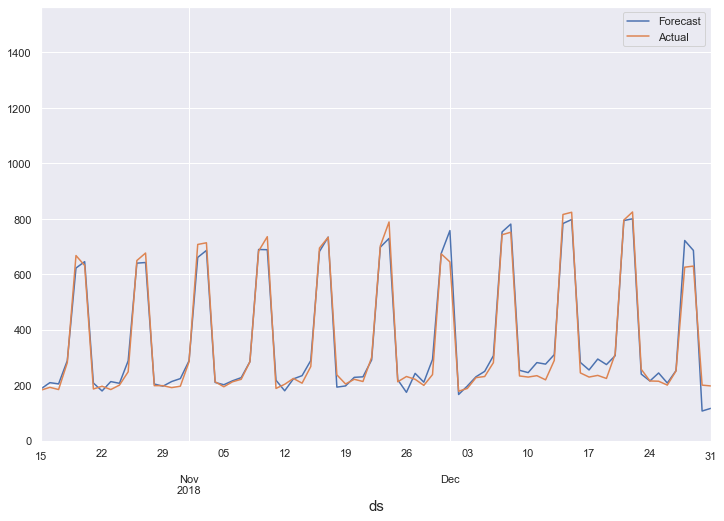

In [12]:
ax = forecast.iloc[period:].plot(x='ds',y='yhat', label='Forecast', 
                                 legend=True,figsize=(12,8));

yc_df.plot(x='ds',y='y',label='Actual',legend=True, xlim = ("2018-10-15", "2018-12-31"), ax = ax);

We can see both the Actual and Forecasted time-series are almost the same, which shows prophet did a good job at generalizing the train set to the test set.

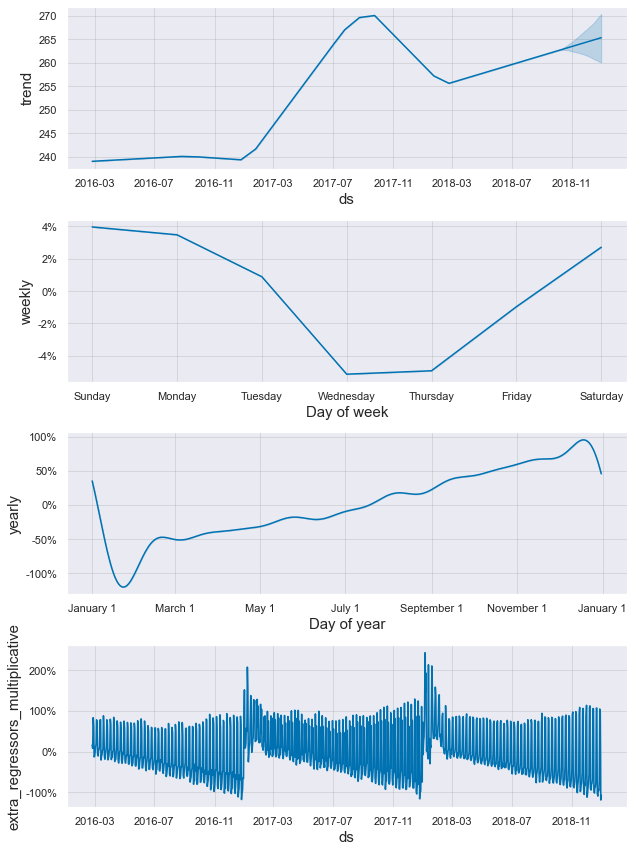

In [13]:
model.plot_components(forecast);

In [14]:
#Evaluating the model. I will use RMSE to evaluate the model.

from statsmodels.tools.eval_measures import rmse

predictions = forecast.iloc[-nobs:]['yhat']
print(len(predictions) - len(test['y']))
print(f"RMSE: {rmse(predictions, test['y'])}")
print(f"mean_pred = {yc_df['y'].mean()}")

0
RMSE: 32.54424817590201
mean_pred = 256.67339097022096


For a mean prediction of 256.67 trips, the RMSE error is only by around 32 trips which is very less. I will check the overall accuracy of the model by subtracting 100% from the Mean Absolute Percentage Error (MAPE).

In [15]:
y_pred = forecast.iloc[-nobs:]['yhat']
y_true = np.array(yc_df.iloc[-nobs:]['y'])
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print(f'Accuracy: {accuracy:.2f} %')

Accuracy: 93.42 %


The model has a forecasting accuracy of around 93.42 % on the test set, which is quite good.
<br>
<br>
Next, I will train on the whole dataset of yellow cabs and forecast daily trips for the next 2 years.

In [16]:
forecast_period = 364*2

m = Prophet(interval_width=0.95, seasonality_mode='multiplicative')
m.fit(yc_df)
future = m.make_future_dataframe(periods=forecast_period,freq='D')
yc_forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


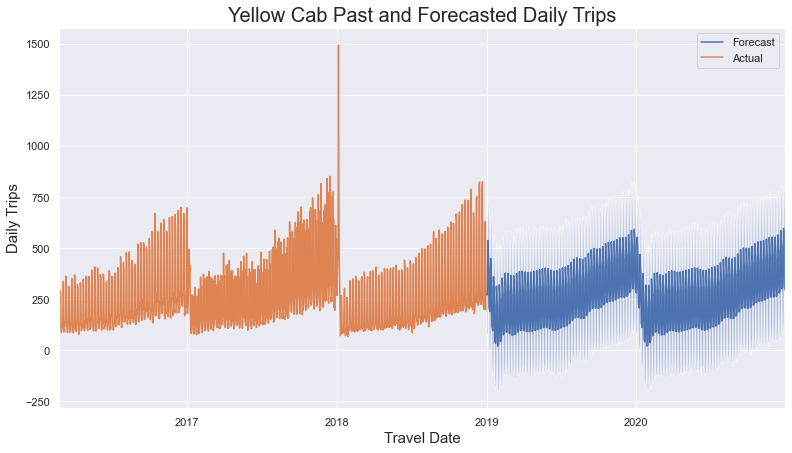

In [17]:
ax = yc_forecast.iloc[-forecast_period:].\
plot(x = 'ds', y = 'yhat', label = 'Forecast', legend = True, figsize = (13,7), 
    title = "Yellow Cab Past and Forecasted Daily Trips")

ax.fill_between(yc_forecast['ds'].iloc[-forecast_period:].values, 
                yc_forecast['yhat_upper'].iloc[-forecast_period:].values, 
                yc_forecast['yhat_lower'].iloc[-forecast_period:].values, alpha = 0.5)

yc_df.plot(x='ds',y='y',label='Actual',legend=True, ax=ax);

ax.set_xlabel('Travel Date');
ax.set_ylabel('Daily Trips');

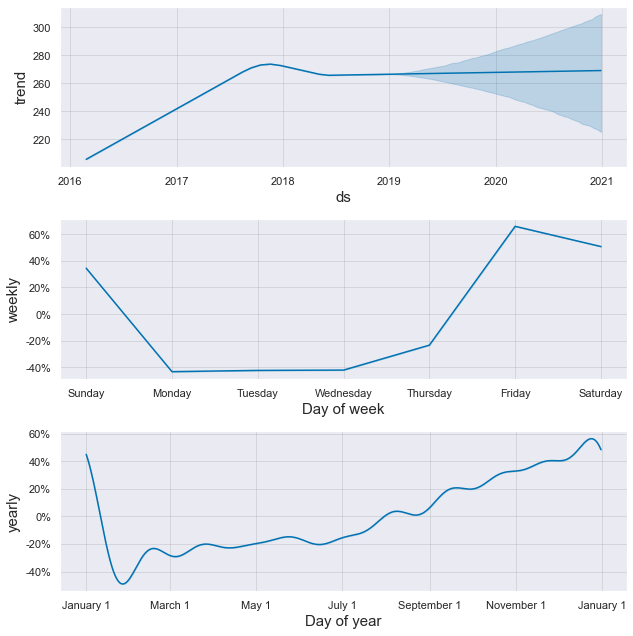

In [18]:
m.plot_components(yc_forecast);

According to the forecast, the overall trend seems to be constant. Of course, it is not ideal to forecast for such a long period, but this will do for now.

# Pink Cab
I will now model and forecast daily trips for Pink Cabs.

In [19]:
pc_df = df.query('company == "Pink Cab"').\
        groupby(['travel_date', 'year', 'month', 'week', 'date', 'day_of_week']).\
        size().reset_index().rename(columns = {0:'trips'})

pc_df

,travel_date,year,month,week,date,day_of_week,trips
0,2016-01-02,2016,1,53,2,5,41
1,2016-01-03,2016,1,53,3,6,52
2,2016-01-04,2016,1,1,4,0,4
3,2016-01-05,2016,1,1,5,1,6
4,2016-01-06,2016,1,1,6,2,23
...,...,...,...,...,...,...,...
1090,2018-12-27,2018,12,52,27,3,66
1091,2018-12-28,2018,12,52,28,4,217
1092,2018-12-29,2018,12,52,29,5,195
1093,2018-12-30,2018,12,52,30,6,56


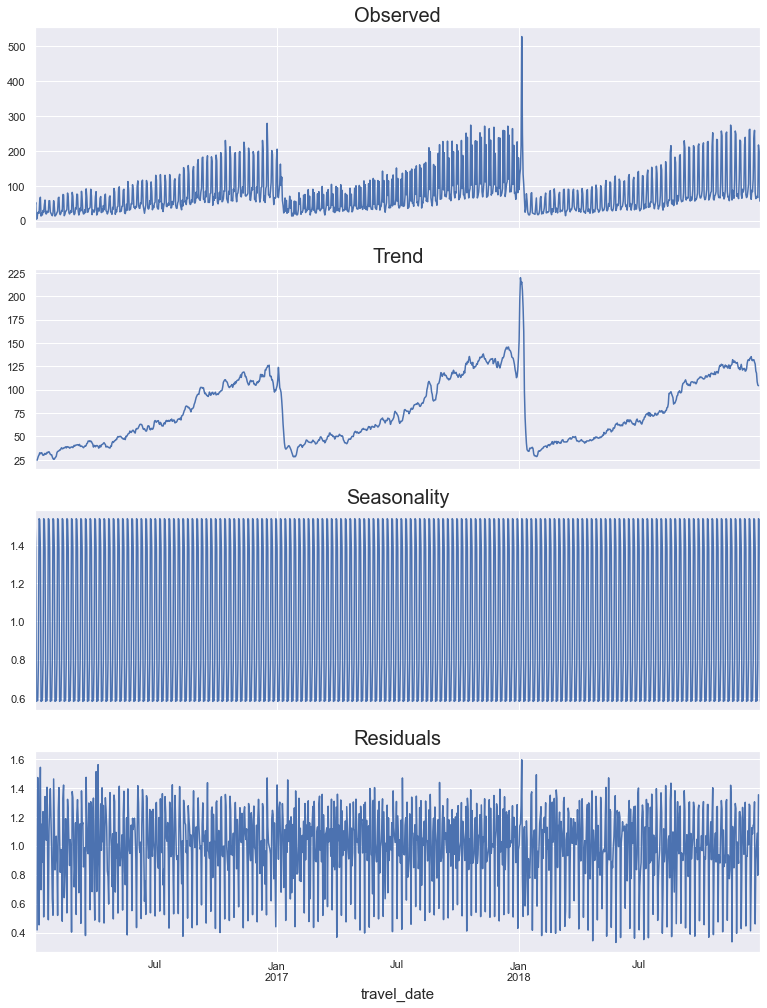

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(pc_df.set_index('travel_date')['trips'], model='mul')  # model='mul' also works

fig, (ax, ax1, ax2, ax3) = plt.subplots(4,1, figsize = (13,17), sharex = True);

result.observed.plot(ax = ax, title = 'Observed')
result.trend.plot(ax=ax1, title = 'Trend');
result.seasonal.plot(ax=ax2, title = 'Seasonality');
result.resid.plot(ax=ax3, title = 'Residuals');

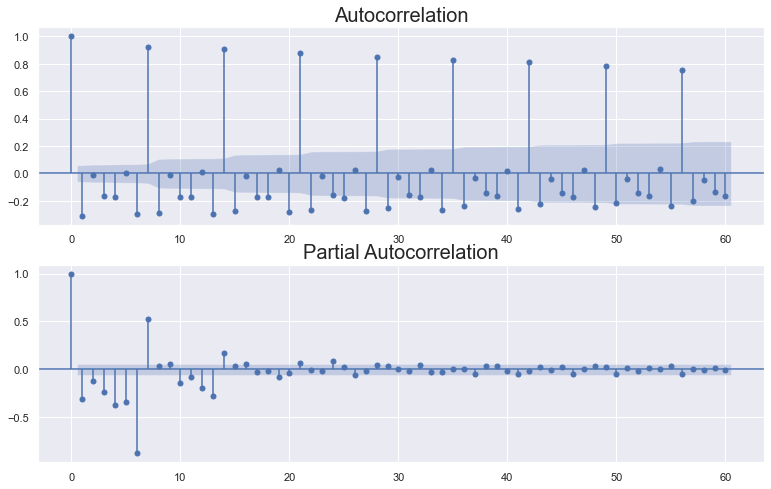

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

lag = 60

fig, ax = plt.subplots(2,1, figsize = (13,8))
plot_acf(pc_df.set_index('travel_date')['trips'].diff(1).dropna(), ax = ax[0], lags = lag);
plot_pacf(pc_df.set_index('travel_date')['trips'].diff(1).dropna(), ax = ax[1], lags = lag);

Similar to yellow cabs, Pink Cabs daily trips are correlated with the number of trips a week ago.

In [22]:
for i in range(54, 0, -1):
   pc_df['t-' + str(i)] = pc_df.trips.shift(i)

pc_df.dropna(inplace = True)

pc_df = pc_df[[
    'travel_date', 'trips', 'year', 'month', 'week', 'date', 'day_of_week',
    't-54', 't-53', 't-52', 't-51', 't-50', 't-49', 't-48', 't-47', 't-46',
    't-45', 't-44', 't-43', 't-42', 't-41', 't-40', 't-39', 't-38', 't-37',
    't-36', 't-35', 't-34', 't-33', 't-32', 't-31', 't-30', 't-29', 't-28',
    't-27', 't-26', 't-25', 't-24', 't-23', 't-22', 't-21', 't-20', 't-19',
    't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10',
    't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']].reset_index(drop = True)

pc_df.rename(columns = {'travel_date' : 'ds', 'trips' : 'y'}, inplace = True)
pc_df.head()

,ds,y,year,month,week,date,day_of_week,t-54,t-53,t-52,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,2016-02-25,29,2016,2,8,25,3,41.0,52.0,4.0,...,14.0,18.0,27.0,28.0,32.0,79.0,65.0,23.0,19.0,23.0
1,2016-02-26,24,2016,2,8,26,4,52.0,4.0,6.0,...,18.0,27.0,28.0,32.0,79.0,65.0,23.0,19.0,23.0,29.0
2,2016-02-27,81,2016,2,8,27,5,4.0,6.0,23.0,...,27.0,28.0,32.0,79.0,65.0,23.0,19.0,23.0,29.0,24.0
3,2016-02-28,70,2016,2,8,28,6,6.0,23.0,24.0,...,28.0,32.0,79.0,65.0,23.0,19.0,23.0,29.0,24.0,81.0
4,2016-02-29,25,2016,2,9,29,0,23.0,24.0,21.0,...,32.0,79.0,65.0,23.0,19.0,23.0,29.0,24.0,81.0,70.0


In [23]:
nobs = 90
period = len(pc_df) - nobs

train = pc_df.iloc[:period]
test = pc_df.iloc[period:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


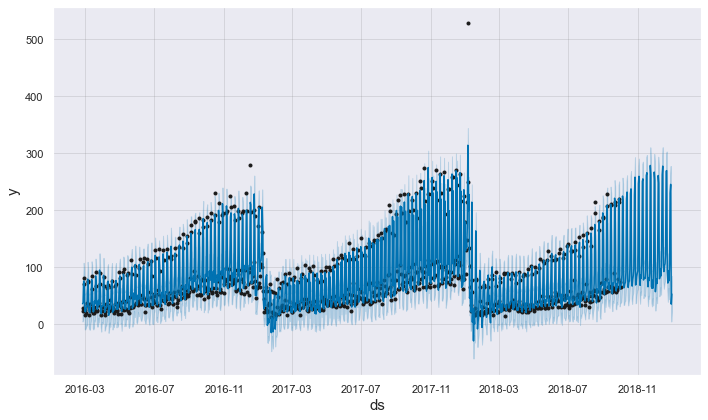

In [24]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95, seasonality_mode='multiplicative')

for i in pc_df.columns[2:]: 
    model.add_regressor(i)

model.fit(train)
future = model.make_future_dataframe(periods=nobs)

for i in pc_df.columns[2:]: 
    future[i] = pc_df[i]

forecast = model.predict(future)

model.plot(forecast);

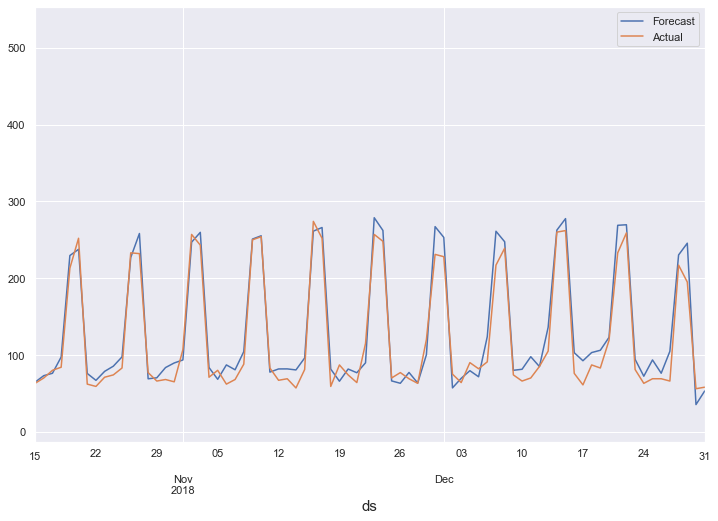

In [25]:
ax = forecast.iloc[period:].plot(x='ds',y='yhat', label='Forecast', 
                                 legend=True,figsize=(12,8));

pc_df.plot(x='ds',y='y',label='Actual',legend=True, xlim = ("2018-10-15", "2018-12-31"), ax = ax);

The forecast is similar to the test set, but not as close compared to Prophet's forecast for Yellow Cab.

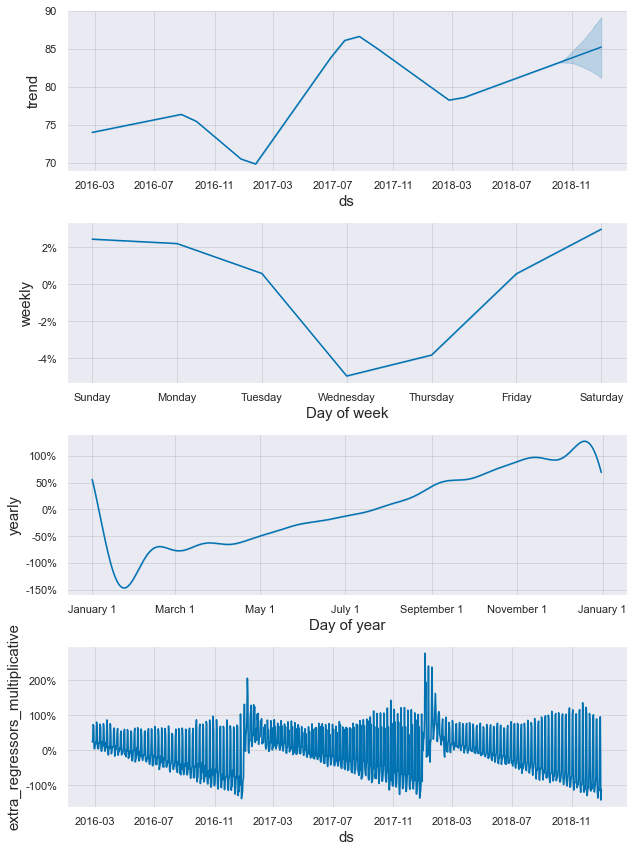

In [26]:
model.plot_components(forecast);

In [27]:
from statsmodels.tools.eval_measures import rmse

predictions = forecast.iloc[-nobs:]['yhat']
print(len(predictions) - len(test['y']))
print(f"RMSE: {rmse(predictions, test['y'])}")
print(f"mean_pred = {pc_df['y'].mean()}")

0
RMSE: 17.620048094982458
mean_pred = 79.6954851104707


In [28]:
y_pred = forecast.iloc[-nobs:]['yhat']
y_true = np.array(pc_df.iloc[-nobs:]['y'])
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print(f'Accuracy:', round(accuracy,2),'%.')

Accuracy: 88.36 %.


The accuracy of the model is lower than yellow cabs, but I judge it's still acceptable.

In [29]:
forecast_period = 364*2

m = Prophet(interval_width=0.95, seasonality_mode='multiplicative')
m.fit(pc_df)
future = m.make_future_dataframe(periods=forecast_period,freq='D')
pc_forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


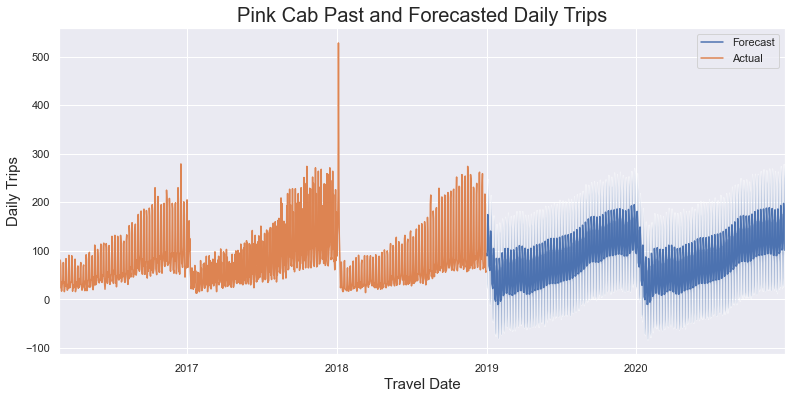

In [30]:
ax = pc_forecast.iloc[-forecast_period:].\
plot(x = 'ds', y = 'yhat', label = 'Forecast', legend = True, figsize = (13,6), 
    title = "Pink Cab Past and Forecasted Daily Trips");

ax.fill_between(pc_forecast['ds'].iloc[-forecast_period:].values, 
                pc_forecast['yhat_upper'].iloc[-forecast_period:].values, 
                pc_forecast['yhat_lower'].iloc[-forecast_period:].values, alpha = 0.5);

pc_df.plot(x='ds',y='y',label='Actual',legend=True, ax=ax);

ax.set_xlabel('Travel Date');
ax.set_ylabel('Daily Trips');

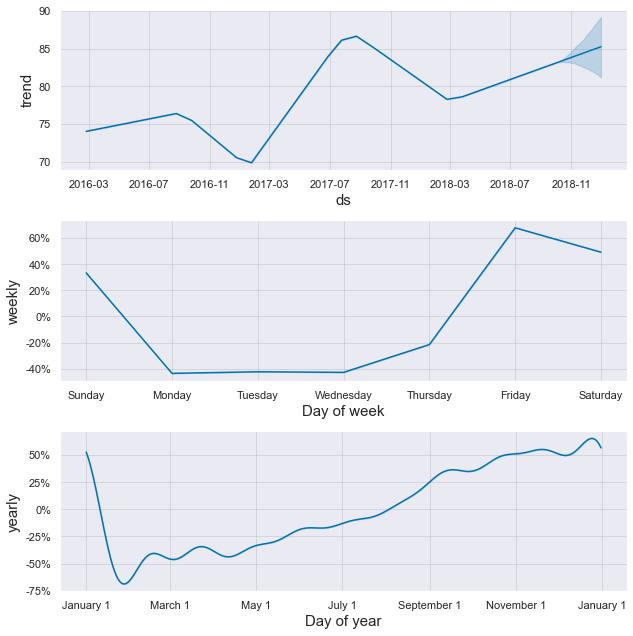

In [31]:
m.plot_components(forecast);

# Comparing Both Cab Company Forecasts

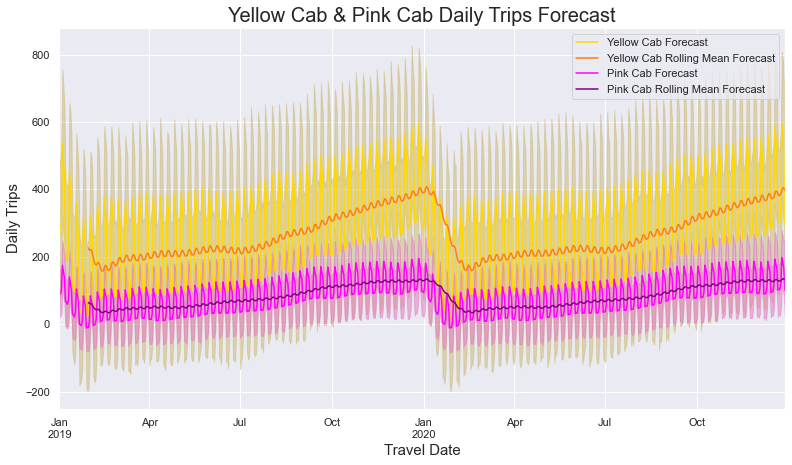

In [32]:
#Yellow Cab Forecast
ax = yc_forecast.iloc[-forecast_period:].plot(x='ds',y='yhat',label='Yellow Cab Forecast',
                                              legend=True,figsize=(15,8), color = 'gold');

# Yellow Cab forecast confidence intervals
ax.fill_between(yc_forecast['ds'].iloc[-forecast_period:].values, 
                yc_forecast['yhat_upper'].iloc[-forecast_period:].values, 
                yc_forecast['yhat_lower'].iloc[-forecast_period:].values, 
                alpha = 0.5, color = 'y');

# Yellow Cab Forecast monthly rolling mean
yc_forecast.iloc[-forecast_period:].set_index('ds').rolling(window=30).mean()['yhat'].\
plot(ax = ax, label = 'Yellow Cab Rolling Mean Forecast', legend = True, color = 'tab:orange');

#Pink Cab Forecast
pc_forecast.iloc[-forecast_period:].\
plot(x='ds',y='yhat',label='Pink Cab Forecast', legend=True,figsize=(13,7), ax = ax, color = 'magenta');

#Pink Cab Forecast confidence intervals
ax.fill_between(pc_forecast['ds'].iloc[-forecast_period:].values,
                pc_forecast['yhat_upper'].iloc[-forecast_period:].values, 
                pc_forecast['yhat_lower'].iloc[-forecast_period:].values, 
                alpha = 0.5, color = 'tab:pink');

#Pink Cab forcast monthly rolling mean
pc_forecast.iloc[-forecast_period:].set_index('ds').rolling(window=30).mean()['yhat'].\
plot(ax = ax, label = 'Pink Cab Rolling Mean Forecast', legend = True, color = 'purple');

#Setting axis labels and Title
ax.set_title('Yellow Cab & Pink Cab Daily Trips Forecast');
ax.set_ylabel('Daily Trips');
ax.set_xlabel('Travel Date');

When comparing both forecasts side by side, we can see Yellow Cab company is projected to still lead in daily trips compared to its rival. 
<br>
<br>
Therefore, from the data, both EDA and the forecasts shows **Yellow Cab** is the right company to be invest in. 